In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect
from sqlalchemy import Column, Integer, String, Float

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
#Set up inspector and get table names
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [11]:
#Get Column Names
columns = inspector.get_columns('measurement')
for column in columns:
    print(column['name'],column['type'])
    


id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
#Get Column Names
columns_2 = inspector.get_columns('station')
for column in columns_2:
    print(column['name'], column['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

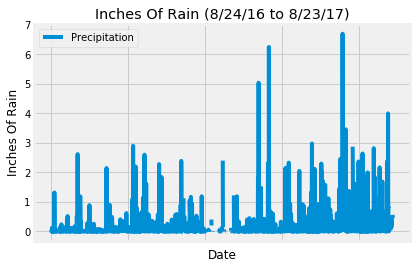

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_date = engine.execute('select max(date) from measurement')
    
# Calculate the date 1 year ago from the last data point in the database. Use dt to subtract 365 days from the date
last_year = dt.date(2017, 8, 23) - dt.timedelta(days = 365)

# Perform a query to retrieve the data and precipitation scores
precip = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > last_year).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(precip)


# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot('date','prcp')
plt.xlabel('Date')
plt.ylabel('Inches Of Rain')
plt.title('Inches Of Rain (8/24/16 to 8/23/17)')
plt.legend(['Precipitation'])
plt.show()



![precipitation](Images/precipitation.png)

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [15]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Station.name).count()

print(f'There are {station_count} stations')


There are 9 stations


In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).\
order_by(func.count(Measurement.tobs).desc()).all()

busiest = active_stations[0][0]

print("The busiest Station was",busiest,"with",active_stations[0][1],"weather observations.")
print('See below for all the stations and their observation counts.')
for record in active_stations:
    print(f'Station {record[0]} had a count of {record[1]}.')

The busiest Station was USC00519281 with 2772 weather observations.
See below for all the stations and their observation counts.
Station USC00519281 had a count of 2772.
Station USC00519397 had a count of 2724.
Station USC00513117 had a count of 2709.
Station USC00519523 had a count of 2669.
Station USC00516128 had a count of 2612.
Station USC00514830 had a count of 2202.
Station USC00511918 had a count of 1979.
Station USC00517948 had a count of 1372.
Station USC00518838 had a count of 511.


In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station? 
temp_desc = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
filter(Measurement.station == busiest)

for record in temp_desc:
    print(f'The lowest temp for station {busiest} is {record[0]}')
    print(f'The highest temp is {record[1]}')
    print(f'The average temp is {record[2]}')


The lowest temp for station USC00519281 is 54.0
The highest temp is 85.0
The average temp is 71.66378066378067


In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
high_station = session.query(Measurement.station, Measurement.tobs, Measurement.date).\
    filter(Measurement.station == busiest).filter(Measurement.date > last_year).\
    order_by(Measurement.date).all()

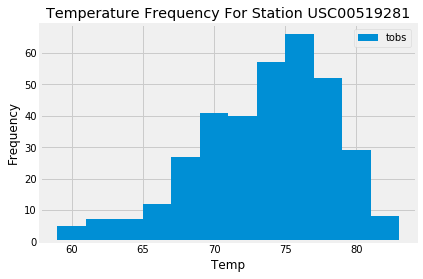

In [20]:
#Turn data in Pandas DF and Plot
temp_df = pd.DataFrame(high_station)
plt.hist(temp_df['tobs'], 12)
plt.xlabel("Temp")
plt.ylabel("Frequency")
plt.title("Temperature Frequency For Station " + busiest)
plt.legend(["tobs"])
plt.show()

![precipitation](Images/station-histogram.png)

In [21]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [63]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start_date_2 = dt.date(2011, 2, 28)
end_date_2 = dt.date(2011,3,5)

trip_temp = calc_temps(start_date, end_date)
print(trip_temp)

[(61.0, 69.75510204081633, 75.0)]


In [64]:
min_temp = trip_temp[0][0]
avg_temp = trip_temp[0][1]
max_temp = trip_temp[0][2]

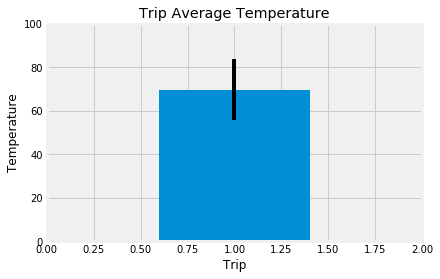

In [65]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig, ax = plt.subplots()
bar = ax.bar(1, avg_temp, yerr = max_temp - min_temp)
ax.set_xlabel("Trip")
ax.set_ylabel("Temperature")
ax.set_title("Trip Average Temperature")

plt.ylim(0,100)
plt.xlim(0,2)

plt.show()



In [88]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
rain_per_station = session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, Measurement.prcp, Measurement.date).\
filter(Station.station == Measurement.station).\
filter(Measurement.date >= start_date_2).\
filter(Measurement.date <= end_date_2).\
group_by(Station.station).\
order_by(Measurement.prcp.desc()).all()

print(f'Station Number,     Station Name,     Lat,    Long,   Elevation,    Precip,     Date')
print('')
for record in rain_per_station:
    print(record)




Station Number,     Station Name,     Lat,    Long,   Elevation,    Precip,     Date

('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 1.42, '2011-03-04')
('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.6, '2011-03-04')
('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.4, '2011-03-05')
('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.29, '2011-03-05')
('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.26, '2011-03-05')
('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.26, '2011-03-05')
('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.22, '2011-03-05')
('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.13, '2011-03-05')
('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None, '2011-03-02')
